In [115]:
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import csv
import pandas as pd
import re
import sklearn
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [116]:
# Load data
orig = pd.read_csv('data/final_data.csv').drop(['Unnamed: 0'], axis=1) # Remove unncessary column 
orig = orig[orig['year'] != 2013] # 2013 has incomplete data, so we will remove it

In [117]:
# Group data by the key features we want to focus on
grouped = pd.DataFrame(orig.groupby(['year', 'month', 'state']).count()['day']).rename(columns={"day":"n_incidents"})
grouped.reset_index(inplace=True)
df = orig.merge(grouped, left_on=['year', 'month', 'state'], right_on=['year', 'month', 'state'])

In [118]:
# Drop extraneous columns
df = df.drop(['incident_id', 'city_or_county', 'address', 'congressional_district', 'incident_characteristics',
             'participant_age', 'participant_gender', 'participant_name', 'participant_relationship', 
             'participant_status', 'participant_type', 'state_house_district', 'state_senate_district', 
             'gun_stolen', 'gun_type',
             'Permit Type'
             ], axis=1)

In [120]:
# One-hot encoding states
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(pd.DataFrame(orig['state']))
encoded = pd.DataFrame(enc.transform(orig[['state']]).toarray())

# Assigning states to column names
state_list = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

encoded.columns = state_list

# Merge with original dataframe
df = df.merge(encoded, left_index=True, right_index=True)
df = df.drop(['state'], axis=1)

,year,month,day,n_killed,n_injured,latitude,longitude,n_guns_involved,n_people,n_young,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2014,1,1,0,1,39.9641,-75.1916,NaN,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014,1,1,0,1,40.0331,-75.1069,NaN,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014,1,1,0,1,40.2138,-74.8426,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014,1,2,0,1,39.9421,-75.1539,NaN,3.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,1,2,0,1,39.9641,-75.1916,NaN,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
# Fill in all missing data: assume that there must be at least one gun involved and that any missing
# ages or locations can be 0 (this has affects on final results)
df['n_guns_involved'] = df['n_guns_involved'].fillna(1)
df = df.fillna(0)

In [123]:
# Move n_incidents to the front for easier manipulation
n_incidents = df['n_incidents']
df.drop(labels=['n_incidents'], axis=1,inplace = True)
df.insert(0, 'n_incidents', n_incidents)

In [125]:
# Group by year and state, send to Tyler
df2 = pd.DataFrame(orig.groupby(['year', 'state']).count()['day']).rename(columns={"day":"n_incidents"})
df2.to_csv('No. Incidents by Year and State')
grouped.to_csv('grouped by year state and month')

In [126]:
# Run ML on state-level incidents (drop incident level data, groupby again)
state_data = pd.read_csv('data/state_data.csv').drop(['Unnamed: 0', 'Handgun_Carry_Permit_Fee', 'Permit Type', 'Years_Valid'], axis=1)
state_data = state_data.rename(index=str, columns={'Mental_Health_Records_Submitted_2008': 'Mental Health 2008', 
                                      'Mental_Health_Records_Submitted_2017': 'Mental Health 2017',
                                      'Gun_Sale_Denials_2008': 'Gun Denials 2008',
                                      'Gun_Sale_Denials_2017': 'Gun Denials 2017',
                                      'Rank': 'Gun Ownership Rank',
                                      '5_Year_Cost': '5 Year Permit Cost'
                                     })

In [127]:
# One-hot encode the new state year month dataframe
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(pd.DataFrame(state_data['state']))
state_encoded = pd.DataFrame(enc.transform(state_data[['state']]).toarray())

# Assigning states to column names
state_list = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

state_encoded.columns = state_list
state_encoded = state_encoded.reset_index()
state_data = state_data.reset_index()

# Merge with original state dataframe
state_data = state_data.merge(state_encoded, left_index=True, right_index=True)
state_data = state_data.drop(['state', 'index_x'], axis=1)

,year,month,n_incidents,Mental Health 2008,Mental Health 2017,Gun Denials 2008,Gun Denials 2017,Giffords_Gun_Safety_Grade,Gun_Death_Rate_2018 (per 100k people),Gun_Death_Rank,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2014,1,70,155,5036,32,125,F,22.9,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014,2,47,155,5036,32,125,F,22.9,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014,3,66,155,5036,32,125,F,22.9,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014,4,71,155,5036,32,125,F,22.9,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,5,66,155,5036,32,125,F,22.9,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
# One-hot encode Giffords gun safety grade
enc_giff = OneHotEncoder(handle_unknown='ignore')
enc_giff.fit(pd.DataFrame(state_data['Giffords_Gun_Safety_Grade']))
giff_encoded = pd.DataFrame(enc_giff.transform(state_data[['Giffords_Gun_Safety_Grade']]).toarray())

# Assigning grades to column names
giff_list = ['A', 'A-', 'B', 'B+', 'C', 'C+', 'C-', 'D', 'D+', 'D-', 'F']
giff_encoded.columns = giff_list

# Merge with original state dataframe
state_data = state_data.merge(giff_encoded, left_index=True, right_index=True)
state_data = state_data.drop(['Giffords_Gun_Safety_Grade', 'index_y'], axis=1)

,year,month,n_incidents,Mental Health 2008,Mental Health 2017,Gun Denials 2008,Gun Denials 2017,Gun_Death_Rate_2018 (per 100k people),Gun_Death_Rank,Gun Ownership Rank,...,A-,B,B+,C,C+,C-,D,D+,D-,F
0,2014,1,70,155,5036,32,125,22.9,2.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2014,2,47,155,5036,32,125,22.9,2.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2014,3,66,155,5036,32,125,22.9,2.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2014,4,71,155,5036,32,125,22.9,2.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2014,5,66,155,5036,32,125,22.9,2.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [145]:
# Run on state-level data - Linear Regression
X = state_data.iloc[:, state_data.columns != 'n_incidents']
y = state_data['n_incidents']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear model
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)
A = reg.coef_
b = reg.intercept_

lin_train, lin_test = reg.score(X_train, y_train), reg.score(X_test, y_test)

In [147]:
# Lasso regularized linear model
reg_lass = linear_model.Lasso(alpha=0.1)
reg_lass.fit(X_train, y_train)
reg_lass.score(X_train, y_train)
A_lass = reg_lass.coef_
b_lass = reg_lass.intercept_

lin_lasso_train, lin_lasso_test = reg_lass.score(X_train, y_train), reg_lass.score(X_test, y_test)

In [156]:
# Lasso regularized linear model with several alphas
alphas_lass = np.linspace(0.000000001, 1.0, 100)
scores_lass_train = []
scores_lass_test = []

for i in alphas_lass:
    reg_lass = linear_model.Lasso(alpha=i)
    reg_lass.fit(X_train, y_train)
    
    scores_lass_train.append(reg_lass.score(X_train, y_train))
    scores_lass_test.append(reg_lass.score(X_test, y_test))

In [158]:
# Ridge regularized linear model with several alphas
from sklearn.linear_model import Ridge

alphas_ridge = np.linspace(0.00001, 1.0, 20)
scores_ridge_train = []
scores_ridge_test = []

for i in alphas_ridge:
    reg_ridge = Ridge(alpha=i)
    reg_ridge.fit(X_train, y_train)
    
    scores_ridge_train.append(reg_ridge.score(X_train, y_train))
    scores_ridge_test.append(reg_ridge.score(X_test, y_test))

In [151]:
# CART model
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

reg_cart = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
reg_cart.fit(X_train, y_train)
reg_train, reg_test = reg_cart.score(X_train, y_train), reg_cart.score(X_test, y_test)

In [152]:
# Polynomial regression for 2 degrees
from sklearn.preprocessing import PolynomialFeatures

poly_reg2 = PolynomialFeatures(degree=2)
X_poly2 = poly_reg2.fit_transform(X_train)
X_test_poly2 = poly_reg2.fit_transform(X_test)

pol_reg2 = LinearRegression()
pol_reg2.fit(X_poly2, y_train)
pol2_train, pol2_test = pol_reg2.score(X_poly2, y_train), pol_reg2.score(X_test_poly2, y_test)

In [153]:
# Polynomial regression with 3 degrees
poly_reg3 = PolynomialFeatures(degree=3)
X_poly3 = poly_reg3.fit_transform(X_train)
X_test_poly3 = poly_reg3.fit_transform(X_test)

pol_reg3 = LinearRegression()
pol_reg3.fit(X_poly3, y_train)
pol3_train, pol3_test = pol_reg3.score(X_poly3, y_train), pol_reg3.score(X_test_poly3, y_test)

In [159]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

depths = np.linspace(2, 25, 20)
scores_rf_train = []
scores_rf_test = []

for i in depths:
    regr = RandomForestRegressor(max_depth=i, random_state=0, n_estimators=100)
    regr.fit(X_train, y_train)
    
    scores_rf_train.append(regr.score(X_train, y_train))
    scores_rf_test.append(regr.score(X_test, y_test))

In [155]:
# Make predictions

# Make dataframe for predictions
predictors = state_data.drop(['n_incidents'], axis=1)
predictors['year'] = predictors['year'] + 5

In [144]:
# Find states that are missing data (no gun incidents for that month)
state_counts = grouped[grouped['year'] != 2018].groupby(['year', 'state']).size().reset_index().rename(columns={0:'count'})
missing = state_counts[state_counts['count'] != 12]

In [140]:
# Add Missing columns
"""
These are the state/year combos that are missing:

Hawaii (2014, 2015, 2017), New Hampshire (2014), 
Wyoming (2014, 2015, 2016, 2017), Maine (2015), 
North Dakota (2015, 2016), South Dakota (2016, 2017),
Vermont (2016, 2017)

"""

"""
Missing months:

Hawaii 2014 2, 5, 10; Hawaii 2015 1; Hawaii 2017 8;
New Hampshire 2014 4;
Wyoming 2014 3, 4, 5; Wyoming 2015 8, 10; Wyoming 2016 5, 12; Wyoming 2017 1, 3, 7, 10;
Maine 2015 9;
North Dakota 2015 4; North Dakota 2016 7, 9;
South Dakota 2016 1; South Dakota 2017 2;
Vermont 2016 4, 7, 8, 10; Vermont 2017 6, 12

"""

# Making dataframes for each
Hawaii_df = predictors[(predictors['Hawaii'] == 1)].iloc[0:1]
NH_df = predictors[(predictors['New Hampshire'] == 1)].iloc[0:1]
Wyoming_df = predictors[(predictors['Wyoming'] == 1)].iloc[0:1]
Maine_df = predictors[(predictors['Maine'] == 1)].iloc[0:1]
ND_df = predictors[(predictors['North Dakota'] == 1)].iloc[0:1]
SD_df = predictors[(predictors['South Dakota'] == 1)].iloc[0:1]
Vermont_df = predictors[(predictors['Vermont'] == 1)].iloc[0:1]

# Inputting "correct" year, month for each state
Hawaii_df = Hawaii_df.append([Hawaii_df]*4, ignore_index=True)
Hawaii_df['year'] = [2019, 2019, 2019, 2020, 2022]
Hawaii_df['month'] = [2, 5, 10, 1, 8]

NH_df['year'] = [2019]
NH_df['month'] = [4]

Wyoming_df = Wyoming_df.append([Wyoming_df]*10, ignore_index=True)
Wyoming_df['year'] = [2019, 2019, 2019, 2020, 2020, 2021, 2021, 2022, 2022, 2022, 2022]
Wyoming_df['month'] = [3, 4, 5, 8, 10, 5, 12, 1, 3, 7, 10]

Maine_df['year'] = [2020]
Maine_df['month'] = [9]

ND_df = ND_df.append([ND_df]*2, ignore_index=True)
ND_df['year'] = [2020, 2021, 2021]
ND_df['month'] = [4, 7, 9]

SD_df = SD_df.append([SD_df], ignore_index=True)
SD_df['year'] = [2021, 2022]
SD_df['month'] = [1, 2]

Vermont_df = Vermont_df.append([Vermont_df]*5, ignore_index=True)
Vermont_df['year'] = [2021, 2021, 2021, 2021, 2022, 2022]
Vermont_df['month'] = [4, 7, 8, 10, 6, 12]

# Merge all databases together
missing_months = Hawaii_df.append([NH_df, Wyoming_df, Maine_df, ND_df, SD_df, Vermont_df])
predictors = predictors.append(missing_months, ignore_index=True)

In [141]:
# Calculate the predictions
predictions = regr.predict(predictors)
predictors['predictions'] = predictions

In [142]:
# Save as csv for Visualization
predictors.to_csv('predictions')

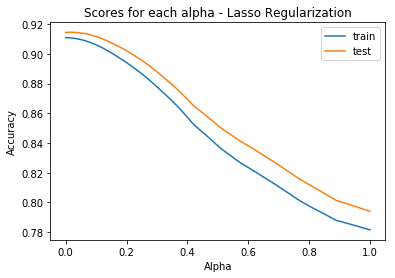

In [171]:
import matplotlib.pyplot as plt
# Table of all results
results = pd.DataFrame(columns=['Train', 'Test'], 
                           index=['Linear Regression','Lasso LR',
                                  'Ridge LR',
                                 'CART', 'Polynomial (d=2)', 'Polynomial (d=3)', 
                                  'Random Forest'])
results.loc['Linear Regression'] = pd.Series({'Train':lin_train, 'Test':lin_test})
results.loc['Lasso LR'] = pd.Series({'Train':np.max(scores_lass_train), 'Test':np.max(scores_lass_test)})
results.loc['Ridge LR'] = pd.Series({'Train':np.max(scores_ridge_train), 'Test':np.max(scores_ridge_test)})
results.loc['CART'] = pd.Series({'Train':reg_train, 'Test':reg_test})
results.loc['Polynomial (d=2)'] = pd.Series({'Train':pol2_train, 'Test':pol2_test})
results.loc['Polynomial (d=3)'] = pd.Series({'Train':pol3_train, 'Test':pol3_test})
results.loc['Random Forest'] = pd.Series({'Train':np.max(scores_rf_train), 'Test':np.max(scores_rf_test)})
results

# Plot of lasso scores
plt.plot(alphas_lass, scores_lass_train, label="train")
plt.plot(alphas_lass, scores_lass_test, label="test")
plt.title('Scores for each alpha - Lasso Regularization')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend();

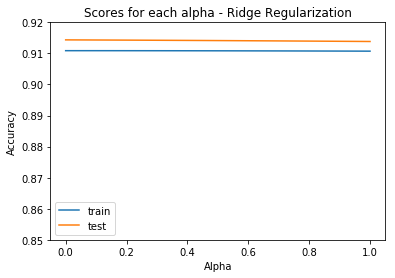

In [177]:
# Plot of ridge scores
plt.plot(alphas_ridge, scores_ridge_train, label="train")
plt.plot(alphas_ridge, scores_ridge_test, label="test")
plt.ylim(0.85, 0.92)
plt.title('Scores for each alpha - Ridge Regularization')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend();

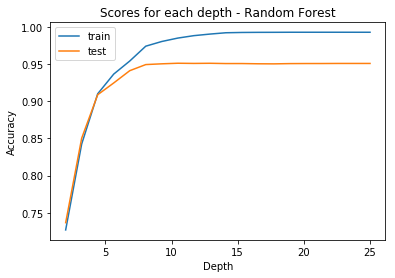

In [178]:
# Plot of Random Forest scores
plt.plot(depths, scores_rf_train, label="train")
plt.plot(depths, scores_rf_test, label="test")
plt.title('Scores for each depth - Random Forest')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend();

In [180]:
# Make a pickle
import pickle
s = pickle.dumps(regr)
random_forest = pickle.loads(s)
pickles = random_forest.predict(predictors)
np.savetxt("pickles.csv", pickles, delimiter=",")